## Modified Schelling segregation model

In this post, we will model the famous Schelling segregation model modifying it to incorporate rare "shock" events during which the urban spatial organization changes drastically.

After setting up a toy urban environment with three populations (each representative of which as a cell) and some empty lots randomly distributed in it, the strategy is as follows:

At each iteration:

   1. Sample a "shock event" from a fat-tailed lognormal distribution with $\mu_{shock} = -2$ and $\sigma_{shock} = 0.65$.
   2. Sample a tolerance threshold from a normal distribution with $\mu = 0.25$ and $\sigma = 0.05$. 
   3. If a "shock event" (an event exceeding the 99th percentile of the lognormal distribution) has not been sampled, all urban       zones with a fraction of similar neighbours smaller than the tolerance threshold selected in step 2 relocate to empty           zones. If a "shock event" has been sampled, the tolerance range shifts to [0.9, 1), meaning that the zones suddenly             become very intolerant to dissimilar neighbors but also in case all neighbors are similar to them. All zones not in this       tolerance range relocate to empty zones.
 


In [6]:
#import necessary libraries
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from matplotlib import gridspec
import pylab as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

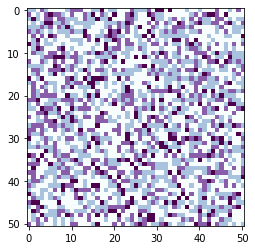

In [2]:
#set up initial urban territory with three different populations in a proportion of 4/3/2
mat = np.random.choice(4, 2601, p=[0.4, 0.3,0.2, 0.1]).reshape(51,51)
plt.imshow(mat, cmap='BuPu')
plt.show()

In [3]:
# define functions for finding the neighbors of a given cell [i,j]

# first level neighbors
def neighbors_1(matrix, i, j):
    m, n = matrix.shape
    rows = [(i-1) % m, i, (i+1) % m]
    cols = [(j-1) % n, j, (j+1) % n]
    return [[rows[i], cols[j]] for i in range(3) for j in range(3) if ((i!=1)|(j!=1))]

# second level neighbors
def neighbors_2(matrix, i, j):
    m, n = matrix.shape
    rows = [(i-2) % m, (i-1) % m, i, (i+1) % m, (i+2) % m]
    cols = [(j-2) % n, (j-1) % n, j, (j+1) % n, (j+2) % n]
    return [[rows[i], cols[j]] for i in range(5) for j in range(5) if ((i!=2)|(j!=2))]

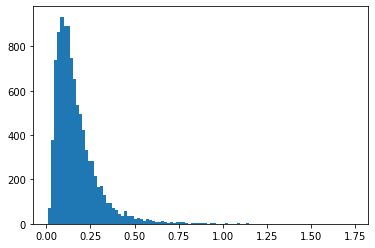

In [4]:
# set up "shock event" distribution
shock_event_dist = np.random.lognormal(-2, 0.65, 10000)
plt.hist(shock_event_dist, bins=100)
plt.show()

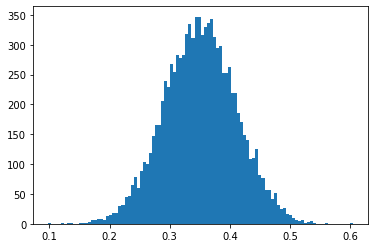

In [5]:
# set up tolerance threshold distribution
thresh_norm_dist = np.random.normal(0.35, 0.06, 10000)
plt.hist(thresh_norm_dist, bins=100)
plt.show()

In [ ]:
#initialize list containing fraction of zones with fraction of similar neighbours exceeding threshold
happies = [] 

# set simulation duration
time = 500

# set up horizontal line at 100% level for visual clarity in the plot
time_array = np.arange(time)
line_at_1 = np.array([100]*time)

# start simulation
for timestep in tqdm_notebook(range(time)):
    #sample similarity tolerance threshold from the normal distribution
    thresh_alike = random.choice(thresh_norm_dist)
    
    #identify coordinates of empty lots
    empty_lots_rows = np.where(mat == 3)[0]
    empty_lots_cols = np.where(mat == 3)[1]
    
    #number of empty lots
    empty_lots_num = (mat == 3).sum()
    
    #initialize list containing coordinates of zones with fraction of similar neighbours not exceeding threshold 
    unhappy_zone_coords = []
    
    # initialize counter for happy zones
    happy_zones = 0
    
    # sample the rare event
    sudden_thresh = random.choice(shock_event_dist) 
    
    #iterate over zones
    for i in range(51):
        for j in range(51):
            
            # initialize counters for similar neighbors and the total number of neighbors
            neighs_alike = 0
            neigh_total = 0
            
            # make sure to skip empty lots
            if mat[i,j]!=3:
                
                # find the neighbors of [i,j]
                neighs_ij = neighbors_2(mat, i, j)
                
                #compute number of similar neighbors and the total number of 
                #neighbors of [i,j] by iterating through its neighbors
                for neigh in neighs_ij:
                    if mat[i,j] == mat[neigh[0], neigh[1]]:
                        neighs_alike += 1
                    if mat[neigh[0], neigh[1]] != 3:
                        neigh_total += 1
                        
                # sample rare event - if sampled non-rare event, then proceed as usual
                if sudden_thresh < np.percentile(s, 99):
                    if true_divide(neighs_alike, neigh_total) > thresh_alike:
                        happy_zones += 1
                    else:
                        unhappy_zone_coords.append([i,j])
                        
                #else simulate 'shock' by making many zones unhappy
                else:
                    if (true_divide(neighs_alike, neigh_total) > 0.7) and (true_divide(neighs_alike, neigh_total) < 1):
                        happy_zones += 1
                    else:
                        unhappy_zone_coords.append([i,j])
                
    happies.append(100*happy_zones/(mat != 3).sum())
    
    #start plotting
    fig = plt.figure(figsize=(14,8), dpi=72)

    ax1=fig.add_subplot(221)
    ax1.set_title('Urban territory')
    ax1.imshow(mat, cmap='BuPu')

    ax2 = fig.add_subplot(222)
    ax2.set_title('Schelling segregation')
    ax2.plot(np.arange(timestep+1), happies, color='darkslateblue', marker='o', markersize=0.5, linewidth=1)
    ax2.plot(time_array,line_at_1, color='red', linestyle='--', linewidth=1)
    
    ins = ax2.inset_axes([0.55,0.15,0.4,0.4])
    ins.patch.set_alpha(0.1)
    
    n, bins, patches = ins.hist(s, 100, density=True, alpha=0.7 ,color='lightsteelblue')
    ins.scatter([sudden_thresh], [0], color='r', alpha=0.5, s=60, zorder=10)
    
    ins.set_xlim(0,1.6)
    ins.set_xticks([0,0.5,1])
    
    ins.spines['right'].set_visible(False)
    ins.spines['top'].set_visible(False)
    ins.spines['left'].set_visible(False)
    ins.spines['bottom'].set_visible(False)
    ins.get_yaxis().set_ticks([])
    ins.tick_params(axis='x', colors='slategrey', labelsize=7)
    ins.tick_params(axis='y', colors='slategrey', labelsize=7)
    
    plt.xlabel('Time')
    plt.ylabel('% with similar neighbors')    
    plt.grid(axis='y', alpha=0.5)
    plt.xlim(0,500)
    plt.ylim(0,110)
    plt.tight_layout()
    fig.savefig('../Schelling/sch_{}.png'.format(timestep), dpi=fig.dpi)
    plt.show() 
    
    #shuffle unhappy zones to relocate them randomly
    np.random.shuffle(unhappy_zone_coords)
    
    #iterate through unhappy zones and change their location to an empty lot
    for unhappy_zone in unhappy_zone_coords:
        empty_lots_rows = np.where(mat == 3)[0]
        empty_lots_cols = np.where(mat == 3)[1]
        empty_lots_num = (mat == 3).sum()
        if empty_lots_num>0:
            rand_choice = random.choice(np.arange(empty_lots_num))
            mat[np.where(mat == 3)[0][rand_choice],np.where(mat == 3)[1][rand_choice]] = mat[unhappy_zone[0], unhappy_zone[1]]
            mat[unhappy_zone[0], unhappy_zone[1]] = 3
        empty_lots_num -= 1
    

In [ ]:
import re
def nice_sort( l ):
    """ Sorts filenames in a directory.
 
    Required arguments:
    l -- iterable containing file names
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

from os import listdir
filenames = listdir('../Schelling/')
filenames = sorted_nicely(filenames)
filenames

In [ ]:
# make gif
import imageio
with imageio.get_writer('Schelling_1.gif', mode='I',fps=14) as writer:
    for filename in tqdm_notebook(filenames):
        image = imageio.imread('../Schelling/{}'.format(filename))
        writer.append_data(image)